In [51]:
import numpy as np
from matplotlib import pyplot as plt

## Constructing a hypercube and $\mu(x)$ that is smooth w.r.t the graph

In [52]:
n = 7
np.random.seed(1)
mu = np.random.random((2**n,1))


In [53]:
smoothing_iterations = 50

for i in range(smoothing_iterations):
    mu_1 = mu.copy()
    for x in range(2**n):
        for b in range(n):
            mu_1[x] += mu[x ^ (2**b)]
    mu_1 /= (n+1)
    tmp = mu
    mu = mu_1
    del(tmp)
    



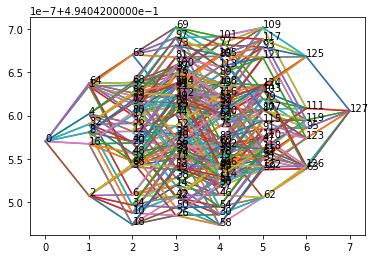

In [54]:
for i in range(2**n):
    plt.annotate(i, [bin(i).count("1"),mu[i]])
    for j in range(n):
        plt.plot([bin(i).count("1"),bin(i ^ (2**j)).count("1")], [mu[i], mu[i^(2**j)]])

## Calculating the diangonal decomposition of $\mathcal{L}$

In [55]:
X = np.zeros((2**n,2**n))
for i in range(2**n):
    for j in range(2**n):
        X[j,i] = -1 if bin(i - (i & j)).count("1") % 2 == 1 else 1

In [56]:
X /= np.sqrt(2**n)

In [57]:
Lmbda = np.array([bin(i).count("1") for i in range(2**n)])*2

## calculating the effective dimension

In [58]:
def calc_effective_d(lmbda, K,T):
    sorted_lmbda = np.sort(lmbda)
    s = 0
    
    while s < lmbda.shape[0] and sorted_lmbda[s] * s - sorted_lmbda[:s].sum() <= T:
        s += 1
    

    h = T - (sorted_lmbda[s-1] * (s-1) - sorted_lmbda[:s-1].sum())
    h = sorted_lmbda[s-1] + h/s

    t_i = h - sorted_lmbda[:s]

    res = 0
    for t,l in zip(t_i, sorted_lmbda):
        res += np.log(1 + t/l)

    return res / np.log(1 + T/(K * sorted_lmbda[0]))

## Spectral UCB

### initialization

In [87]:
lmbda = 1e-3
delta = 1e-1
K = 1
T = 100
sigma = 1e-2
C = mu.T @ X @ np.diag(Lmbda + lmbda) @ X.T @ mu



V = Lmbda + lmbda
V_inv = 1 / V

V = np.diag(V)
V_inv = np.diag(V_inv)
alpha_hat = np.zeros(2**n)

effective_d = calc_effective_d(Lmbda + lmbda, K,T)

c = sigma * np.sqrt(2 * effective_d * np.log(1 + T/(K * lmbda)) + 8 * np.log(1/delta)) + C



In [88]:
predictions = []
rewards = []
x_r_sum = 0
for t in range(T):
    a_t = np.argmax([X[i,:]@alpha_hat + c * np.sqrt(X[i,:]@V_inv@X[i,:]) for i in range(2**n)])

    predictions.append(a_t)
    reward = mu[a_t] + np.random.normal(0,sigma)

    rewards.append(reward)
    x_r_sum += X[a_t,:] * reward
    
    tmp = X[a_t,:].reshape((-1,1))@X[a_t,:].reshape((1,-1))
    V_inv -= 1/(1 + X[a_t,:]@V_inv@X[a_t,:]) * V_inv @ tmp @ V_inv
    V += tmp


    alpha_hat = V_inv @ x_r_sum


### plot: $a_t$ over t

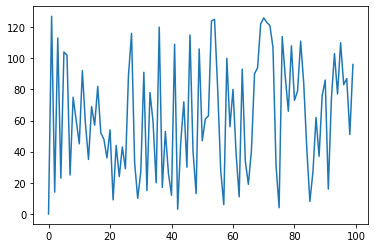

In [89]:
plt.plot(predictions)

### plot : histogram of $a_t$ in $T$ rounds

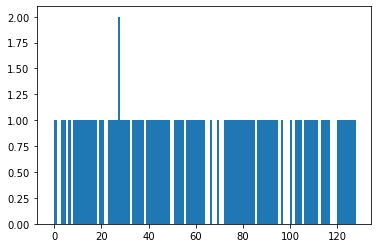

In [90]:
tmp = plt.hist(predictions, bins=range(-1,2**n+1))


### plot: regret $R_T$ over $T$

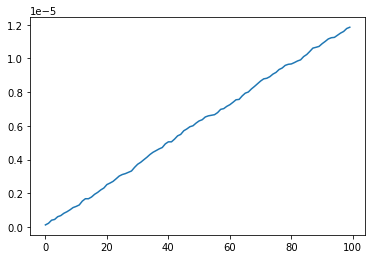

In [91]:
regret = [max(mu) - mu[predictions[i]] for i in range(len(predictions))]

plt.plot(np.cumsum(regret))

### plot: $d_{eff}$ over time horizon $T$

In [92]:
rng = np.arange(10,100000)
tmp = [calc_effective_d(Lmbda + lmbda, 1, T) for T in rng] 

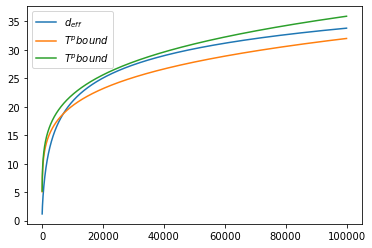

In [93]:
plt.plot(tmp, label="$d_{eff}$")
pw =.20
scale = 3.2
plt.plot(rng**pw * scale, label="$T^p bound$")
plt.plot(rng**(pw+.01) * scale, label="$T^p bound$")

# plt.plot(np.log(rng)*.99*scale)
# plt.plot(np.log(rng)*1.08*scale)

plt.legend()